In [94]:
import numpy as np
import math
from p import Pages
import matplotlib.pyplot as plt


In [95]:

def get_B(R, A, B, G, P):
    # Step 1: check what point it is
    x = P[0]
    y = P[1]

    # Initialize output
    Bout = 0
    # Update output, if needed
    for k in range(len(A)):
        
        m1 = math.tan(math.pi/2 - float(A[k][0]))
        m2 = math.tan(math.pi/2 - float(A[k][1]))
        
        if y < m1*x - R and y >= m2*x - R:  # if P is in Area k

            d = math.sqrt(x**2 + (y-(-R))**2)
            h = R - d
            Bout = float(B[k]) + float(G[k])*h
            break
 
    return Bout



def rot_matrix(alpha):
    R = np.array([[np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha), np.cos(alpha)]]) # Defining the rotation matrix in a clockwise direction
    return R


def next_point(r, P, D):
    
    s = 0.1 # Step size

   
    pc = np.matmul(rot_matrix(-math.pi/2), D) # Multiplying the two matrices together to get the vector going from the point to the center
    pc = r *pc 

    Cx = P[0]+pc[0]
    Cy = P[1]+pc[1]
    c = np.array([Cx, Cy])
   
    CP = np.subtract(P, c) # Subtracting the center from the point to find CP
    r += 1e-10
    theta = s/r
  
    CP2 = np.matmul(rot_matrix(-theta), CP)
    P2 = np.add(c,CP2) # Adding the distance from the center of the circle with the coordinates of the center to find the coordinates of the new point

    PC2 = -CP2
    D2 = np.matmul(rot_matrix(math.pi/2), PC2)

    # Compute the magnitude of the vector
    magnitude = np.linalg.norm(D2) 
    # Normalize the vector
    D2 = D2/magnitude  


    return P2, D2   




def get_points(R, A, B, G, P, D, Energy, size):

    # Compute the magnitude of the vector for normalization
    magnitude = np.linalg.norm(D) 
    # Normalize the vector
    eps = 1e-10
    D = D/(magnitude+eps) # Normalizing the vector and adding a tiny constant to avoid division by zero error

    B_e = 3.3356*(Energy/1000) # Beam Rigidity
    s = 0.1 # Step size

    points = []
    points.append([float(P[0]), float(P[1])])

    directions = []

    trajectory_len = float(size)
    num_steps = trajectory_len/s

    for i in range(int(num_steps)):

        Bout = get_B(R, A, B, G, P)
        if Bout != 0:
            bending_rad = abs(B_e/Bout) # Radius
            P, D = next_point(bending_rad,P,D) # Calculating the next point
        else: # If the magnetic field is zero at this point the particle just continues in a straight line
            P2 = s*D
            P = np.add(P, P2)

        points.append(P)
        directions.append(D)
     
    # Splitting the data into x and y coordinates for plotting
    x = [point[0] for point in points]
    y = [point[1] for point in points]


    return x,y,directions



In [96]:



def default2(A, li, R):
    """ This function creates the default preview that the user can see without having to input X_min, X_max, Y_min, Y_max"""


    X_min = -0.4
    X_max = R + 0.7
    Y_min = -R-0.4
    Y_max = 0.2
    a = 0 # X coordinate of center of circle
    b = -R # Y coordinate of center of circle
    stepSize = 0.001 # Stepsize of line of circle

    # This is to calculate the coordinates of the circles circumference
    positions = []
    t = 0
    while t < 2 * math.pi:
        positions.append((R*math.cos(t) + a, R*math.sin(t) + b))
        t += stepSize
    X = []
    Y = []
    for i in positions:
        x, y = i
        X.append(x)
        Y.append(y)

    # Initiating the plot
    fig, ax = plt.subplots(figsize=(10,10)) 
    # Adding the line to the plot
    ax.plot(X, Y, color='black')

    # This is to split the Vector into B and G
    d = dict()
    for i in range(len(li[0])):
        d[i] = []
        for j in range(len(li)):
            try:
                d[i].append(li[j][i])
            except IndexError:
                d[i].append(0)
    B = d[0]
    try:
        G = d[1]
    except KeyError: # If the user only input vector of size one, we just make G a vector of 0's
        G = []
        for i in range(len(li)):
            G.append(0)

    a = A # This is just to not confuse the old alpha with the "new"
    A = []
    curr = 0
    # This part calculates the beginning point and end point of alpha
    for i in range(len(a)):
        A.append([curr, curr + float(a[i])])
        curr += float(a[i])


    # This makes the coordinates of the points and initiates the magnetic field vector
    X = np.linspace(X_min, X_max, num=100)
    Y = np.linspace(Y_min, Y_max, num=100)
    xx, yy = np.meshgrid(X, Y)
    mag_field = np.zeros_like(xx)

    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            P = xx[i, j], yy[i, j] # Here we define the coordinates of the point
            mag_field[i, j] = get_B(R, A, B, G, P) # Here we calculate the magnetic field at position P

    color_mesh = ax.pcolormesh(xx, yy, mag_field, cmap='Reds') # This line makes the actual plot

    # This is just for customizing the look of the plot
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    colorbar = plt.colorbar(color_mesh, ax=ax)
    colorbar.set_label('Magnetic Field (T)')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim([X_min, X_max])
    ax.set_ylim([Y_min, Y_max])
    



    beams = {'Energies': {'file1': [[100.0], [100.0], [100.0]], 
                          'file2': [[120.0], [120.0], [120.0]], 
                          'file3': [[140.0], [140.0], [140.0]]},
            'Positions': {'file1': [[-0.2, 0.0], [-0.2, 0.001], [-0.2, 0.0]],
                           'file2': [[-0.2, 0.0], [-0.2, 0.001], [-0.2, 0.0]], 
                            'file3': [[-0.2, 0.0], [-0.2, 0.001], [-0.2, 0.0]]}, 
            'Directions': {'file1': [[1, 0], [1, 0], [0.9999995, 0.001]], 
                           'file2': [[1, 0], [1, 0], [0.9999995, 0.001]],
                             'file3': [[1, 0], [1, 0], [0.9999995, 0.001]]}}
        

    def flatten_list(beams_list):
        return [item for sublist in beams_list for item in sublist]

    exit_direction = {}
    xx = {}
    yy ={} 
    dd = {} 

    all_x = {}
    all_y = {}
    all_d_x = {}

    indicies = {}





    def calculate_averages(file_data):
        averages = {"Positions": None, "Directions": None, "Energies": None}

        for category, data in file_data.items():
            if category == "Energies":
                averages[category] = sum(val[0] for val in data) / len(data)
            else:
                averages[category] = [sum(val[i] for val in data) / len(data) for i in range(len(data[0]))]

        return averages



    for file in beams['Energies'].keys():

        energy = beams['Energies'][file]
        positions = beams['Positions'][file]
        directions = beams['Directions'][file]
        energies = flatten_list(beams['Energies'][file])

        xx[file] = []
        yy[file] = []
        dd[file] = []

        for j in range(len(positions)):
            x, y, dirs = get_points(R, A, B, G, [positions[j][0], positions[j][1]], [directions[j][0], directions[j][1]], energies[j], 2)  # Plotting the beam
            plt.plot(x,y)
            xx[file].append(x); yy[file].append(y); dd[file].append(dirs)

        file_data = {'Energies': energy, 'Positions': positions, 'Directions': directions}


     
        exit_direction[file] = []
        all_x[file] = []
        all_y[file] = []
        all_d_x[file] = []

        indicies[file] = []

        for j in range(len(positions)):

            averages = calculate_averages(file_data)
            positions = averages['Positions']
            directions = averages['Directions']
            energies = averages['Energies']

            x, y, dirs = get_points(R, A, B, G, [positions[0], positions[1]], [directions[0], directions[1]], energies, 2)  # Plotting the beam

            first_and_second_elements = [list(arr[:2]) for arr in dirs]


            previous_dir = dirs[-1]
            for i, dir in enumerate(dirs[::-1]):
                if not np.array_equal(dir, previous_dir):
                    ax.scatter(x[len(dirs) - i], y[len(dirs) - i])
                    indicies[file].append(len(dirs) - i)
                    exit_direction[file].append(dir)
                    all_x[file].append(x)
                    all_y[file].append(y)
                    all_d_x[file].append(first_and_second_elements)
                    break
                previous_dir = dir

            break


    
    return xx, yy, exit_direction, indicies, dd


### Function to calculate the size of each beam at the exit

In [97]:
def exit_size(x_list, y_list, index):

    x_positions = []; y_positions = []

    for x_sublist, y_sublist in zip(x_list, y_list):

        # get the item at 'index' in the sublist
        x_pos = x_sublist[index[0]]
        y_pos = y_sublist[index[0]]

        x_positions.append(x_pos); y_positions.append(y_pos)

    average_x_position = sum(x_positions) / len(x_positions)
    average_y_position = sum(y_positions) / len(y_positions)


    avg_pos = (average_x_position, average_y_position)

    coordinates = list(zip(x_positions, y_positions))

    # calculate the Euclidean distances and find the maximum
    distances = [((x-avg_pos[0])**2 + (y-avg_pos[1])**2)**0.5 for x, y in coordinates]
    max_distance = max(distances)
    max_coordinate = coordinates[distances.index(max_distance)]



    return max_distance

### Function to calculate the beam disparity at exit

In [98]:
def beam_disparity(directions, index):
    # Flattening the list
    # Calculate the average directional vector
    # Calculate the angles between the average vector and each other vector
    
    angles = []

    dir_at_index = []
    for inner_list in directions:
        if index[0] < len(inner_list):
            dir_at_index.append(inner_list[index[0]])

    average_vector = np.mean(dir_at_index, axis=0)
    for vec in dir_at_index:
        
        # Calculate the dot product
        dot_product = np.dot(average_vector, vec)

        # # Calculate the magnitudes
        mag_average_vector = np.linalg.norm(average_vector)
        mag_v = np.linalg.norm(vec)

        # Calculate the cosine of the angle
        cos_theta = dot_product / (mag_average_vector * mag_v)

        # Calculate the angle in degrees
        cos_theta = np.clip(cos_theta, -1, 1)

        theta = np.arccos(cos_theta) * (180.0 / np.pi)
        angles.append(abs(theta))
    
    return max(angles)



### Function to calculate angle between inner most and outermost beam

In [99]:
def beam_diff(beam_exit_directions, indeces):

    # Caluclate the average particle exit direction of the first beam
    first_key = list(beam_exit_directions.keys())[0]
    first_beam = beam_exit_directions[first_key]
    first_index = list(indeces.values())[0]

    avg_first_beam_particles = []
    for inner_list in first_beam:
   
        if first_index[0] < len(inner_list):
            avg_first_beam_particles.append(inner_list[first_index[0]])

    average_first_vector = np.mean(avg_first_beam_particles, axis=0)



    # Caluclate the average particle exit direction of the last beam
    last_key = list(beam_exit_directions.keys())[-1]
    last_beam = beam_exit_directions[last_key]
    last_index = list(indeces.values())[-1]

    avg_last_beam_particles = []
    for inner_list in last_beam:
   
        if last_index[0] < len(inner_list):
            avg_last_beam_particles.append(inner_list[last_index[0]])

    average_last_vector = np.mean(avg_last_beam_particles, axis=0)
   

    # Calculate the dot product
    dot_product = np.dot(average_first_vector, average_last_vector)

    # # Calculate the magnitudes
    mag_first_vector = np.linalg.norm(average_first_vector)
    mag_last_vector = np.linalg.norm(average_last_vector)

    # Calculate the cosine of the angle
    cos_theta = dot_product / (mag_first_vector * mag_last_vector)
    cos_theta = np.clip(cos_theta, -1, 1)

    # Calculate the angle in degrees
    theta = np.arccos(cos_theta) * (180.0 / np.pi)


    return abs(theta)

### Section that calculates all positions and directions

In [100]:


def trajectory(A, li, R):
    """ This function creates the default preview that the user can see without having to input X_min, X_max, Y_min, Y_max"""



    # Default values for x_min, x_max, y_min, y_max
    X_min = -0.4
    X_max = R + 0.7
    Y_min = -R-0.4
    Y_max = 0.2
    a = 0 # X coordinate of center of circle
    b = -R # Y coordinate of center of circle
    stepSize = 0.001 # Stepsize of line of circle




    # This is to split the Vector into B and G
    d = dict()
    for i in range(len(li[0])):
        d[i] = []
        for j in range(len(li)):
            try:
                d[i].append(li[j][i])
            except IndexError:
                d[i].append(0)
    B = d[0]
    try:
        G = d[1]
    except KeyError: # If the user only input vector of size one, we just make G a vector of 0's
        G = []
        for i in range(len(li)):
            G.append(0)

    a = A # This is just to not confuse the old alpha with the "new"
    A = []
    curr = 0
    # This part calculates the beginning point and end point of alpha
    for i in range(len(a)):
        A.append([curr, curr + float(a[i])])
        curr += float(a[i])



    # This makes the coordinates of the points and initiates the magnetic field vector
    X = np.linspace(X_min, X_max, num=100)
    Y = np.linspace(Y_min, Y_max, num=100)
    xx, yy = np.meshgrid(X, Y)
    mag_field = np.zeros_like(xx)

    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            P = xx[i, j], yy[i, j] # Here we define the coordinates of the point
            mag_field[i, j] = get_B(R, A, B, G, P) # Here we calculate the magnetic field at position P







    beams = {'Energies': {'file1': [[100.0], [100.0], [100.0]], 
                          'file2': [[120.0], [120.0], [120.0]], 
                          'file3': [[140.0], [140.0], [140.0]]},
            'Positions': {'file1': [[-0.2, 0.0], [-0.2, 0.001], [-0.2, 0.0]],
                           'file2': [[-0.2, 0.0], [-0.2, 0.001], [-0.2, 0.0]], 
                            'file3': [[-0.2, 0.0], [-0.2, 0.001], [-0.2, 0.0]]}, 
            'Directions': {'file1': [[1, 0], [1, 0], [0.9999995, 0.001]], 
                           'file2': [[1, 0], [1, 0], [0.9999995, 0.001]],
                             'file3': [[1, 0], [1, 0], [0.9999995, 0.001]]}}
        


    def flatten_list(beams_list):
        return [item for sublist in beams_list for item in sublist]

    exit_direction = {}
    xx = {}
    yy ={} 
    dd = {} 
    indicies = {}



    def calculate_averages(file_data):
        averages = {"Positions": None, "Directions": None, "Energies": None}

        for category, data in file_data.items():
            if category == "Energies":
                averages[category] = sum(val[0] for val in data) / len(data)
            else:
                averages[category] = [sum(val[i] for val in data) / len(data) for i in range(len(data[0]))]

        return averages



    for file in beams['Energies'].keys():

        energy = beams['Energies'][file]
        positions = beams['Positions'][file]
        directions = beams['Directions'][file]
        energies = flatten_list(beams['Energies'][file])

        xx[file] = []
        yy[file] = []
        dd[file] = []

        for j in range(len(positions)):
            x, y, dirs = get_points(R, A, B, G, [positions[j][0], positions[j][1]], [directions[j][0], directions[j][1]], energies[j], 2)  # Plotting the beam
           # plt.plot(x,y)
            xx[file].append(x); yy[file].append(y); dd[file].append(dirs)

        file_data = {'Energies': energy, 'Positions': positions, 'Directions': directions}

     
        exit_direction[file] = []
   
        indicies[file] = []

        for j in range(len(positions)):

            averages = calculate_averages(file_data)
            positions = averages['Positions']
            directions = averages['Directions']
            energies = averages['Energies']

            x, y, dirs = get_points(R, A, B, G, [positions[0], positions[1]], [directions[0], directions[1]], energies, 2)  # Plotting the bea


            previous_dir = dirs[-1]
            for i, dir in enumerate(dirs[::-1]):
                if not np.array_equal(dir, previous_dir):
                    indicies[file].append(len(dirs) - i)
                    exit_direction[file].append(dir)
                    break          
                previous_dir = dir

    return xx, yy, exit_direction, indicies, dd


In [101]:
def flatten(li):
    """Flatten the list of lists to a single list."""
    return [item for sublist in li for item in sublist]

def reshape(flat_list):
    """Reshape the flattened list back to the list of lists form."""
    return [flat_list[i:i+2] for i in range(0, len(flat_list), 2)]


### Objective function including goal

In [120]:
import numpy as np

def objective(params):

   
    # Extract A and li from params
    A = [params[0]]
    flat_li = params[1:]
    li = reshape(flat_li) 
    R = 0.7

    # Get the beam results from the default2 function
    x, y, _, indices, dd = trajectory(A, li, R)


    results_beam_sizes = [
        exit_size(x['file1'], y['file1'], indices['file1']),
        exit_size(x['file2'], y['file2'], indices['file2']),
        exit_size(x['file3'], y['file3'], indices['file3'])
    ]

    average_beam_size = sum(results_beam_sizes) / len(results_beam_sizes)

    results_beam_disparity = [
        beam_disparity(dd['file1'],indices['file1']),
        beam_disparity(dd['file2'],indices['file2']),
        beam_disparity(dd['file3'],indices['file3'])
    ]

    average_beam_disparity = sum(results_beam_disparity) / len(results_beam_disparity)


    initial_a = beam_diff(dd, indices)
    initial_b = average_beam_size
    initial_d = average_beam_disparity



    a = 40
    b = 0.001
    d = 0.001


    # Gradients
    grad_a = 2 * (initial_a - a)
    grad_b = 2 * (initial_b - b)
    grad_d = 2 * (initial_d - d)

    # Objective function
    f = (initial_a - a)**2 + (initial_b - b)**2 + (initial_d - d)**2
    
    return f


### Optimization

In [129]:
import numpy as np
from scipy.optimize import minimize
import math
import scipy.optimize

# Initial guesses
A_init = [1, 1]
mag_init = [[0.7, 0.5], [0.7, 0.5]]

# Number of rows is based on the length of A_init
num_rows = len(A_init)
mag_matrix = np.array(mag_init).reshape(num_rows, -1)
initial_guess = np.hstack((np.array(A_init).reshape(-1, 1), mag_matrix))

# Bounds
A_bounds = (30*math.pi/180, 60*math.pi/180)
li_bounds_1 = (0.4, 1)
li_bounds_2 = (-2.5, 2.5)


bounds = [A_bounds, A_bounds, li_bounds_1, li_bounds_1, li_bounds_2, li_bounds_2]


# Call minimize
# solution, fval, info = scipy.optimize.fmin_l_bfgs_b(objective, initial_guess.flatten(), bounds=bounds, approx_grad=True,pgtol=1)
# optimized_values = solution
# optimized_A = optimized_values[:2]
# optimized_li = optimized_values[2:].reshape(num_rows, -1)

result = minimize(objective, initial_guess.flatten(), method='Nelder-Mead', options={'maxiter': 15000, 'maxfev': 15000})



print("Initial Guess:", initial_guess)
print("Bounds:", bounds)


from scipy.optimize import differential_evolution

result = differential_evolution(objective, bounds)

if result.success:
    print(result.x)
    optimized_values = result.x
    optimized_A = optimized_values[:2]
    optimized_li = [[optimized_values[2], optimized_values[4]], [optimized_values[3], optimized_values[5]]]
    print("Optimized A:", optimized_A)
    print("Optimized li:", optimized_li)
else:
    print("Optimization did not converge:", result.message)


Initial Guess: [[1.  0.7 0.5]
 [1.  0.7 0.5]]
Bounds: [(0.5235987755982988, 1.0471975511965976), (0.5235987755982988, 1.0471975511965976), (0.4, 1), (0.4, 1), (-2.5, 2.5), (-2.5, 2.5)]
[ 1.00467873  1.04719755  0.58715041  0.5345037   2.46987404 -2.16339767]
Optimized A: [1.00467873 1.04719755]
Optimized li: [[0.5871504110130532, 2.469874038756052], [0.5345037008486759, -2.1633976739953047]]


In [126]:
optimized_li = [[optimized_values[2], optimized_values[4]], [optimized_values[3], optimized_values[5]]]


20.885504070140534

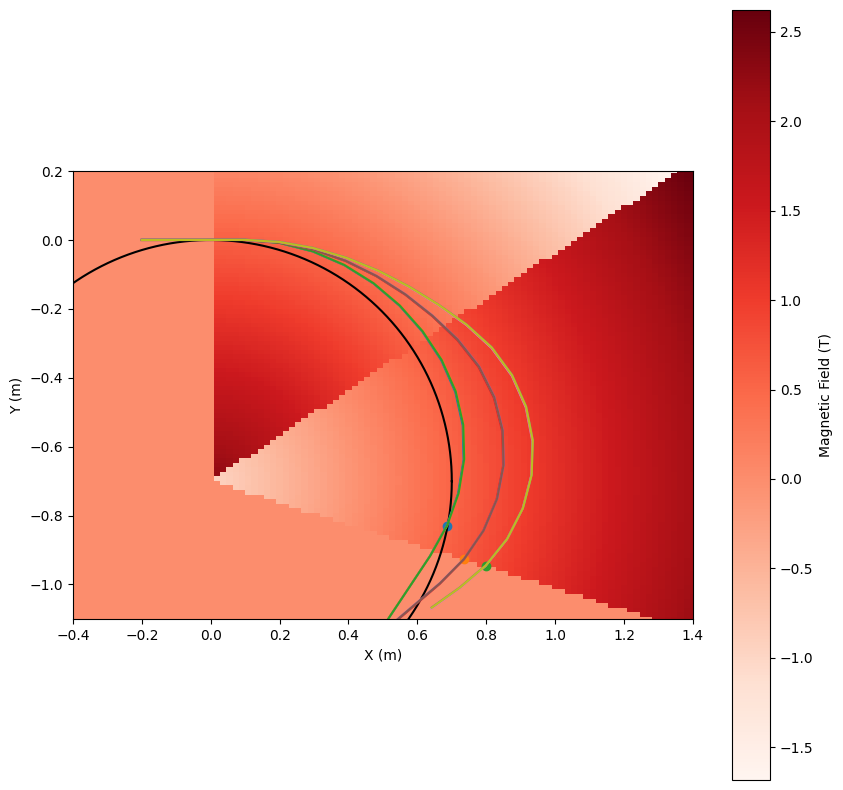

In [131]:

#[ 0.66962189  1.26172088 -0.01930647  1.003688   -0.01165914  0.64327872]

R = 0.7
Optimized_li = [[1.10842445, 0.47544297], [0.12551244, 1.98873132]]
optimized_A = [0.98570755, 0.8869942]
xx, yy, exit_direction, indicies, dd = default2(optimized_A, optimized_li, R)
beam_diff(dd, indicies)

In [ ]:

beams = {'Energies': {'file1': [[100.0], [100.0], [100.0]], 
                          'file2': [[160.0], [160.0], [160.0]], 
                          'file3': [[140.0], [140.0], [140.0]]},
            'Positions': {'file1': [[-0.2, 0.0], [-0.2, 0.001], [-0.2, 0.0]],
                           'file2': [[-0.2, 0.0], [-0.2, 0.001], [-0.2, 0.0]], 
                            'file3': [[-0.2, 0.0], [-0.2, 0.001], [-0.2, 0.0]]}, 
            'Directions': {'file1': [[1, 0], [1, 0], [0.9999995, 0.001]], 
                           'file2': [[1, 0], [1, 0], [0.9999995, 0.001]],
                             'file3': [[1, 0], [1, 0], [0.9999995, 0.001]]}}





# Compute the sums for each file
sums = {file: sum(beams['Energies'][file][0]) for file in beams['Energies']}

# Sort file names based on their sums
sorted_files = sorted(sums, key=sums.get)

# Create a new dictionary with the data reordered
sorted_beams = {
    'Energies': {file: beams['Energies'][file] for file in sorted_files},
    'Positions': {file: beams['Positions'][file] for file in sorted_files},
    'Directions': {file: beams['Directions'][file] for file in sorted_files}
}

print(sorted_beams)


In [ ]:
# Initial guesses
A_init = [0.7, 1, 1.57]
mag_init = [[0.6, 1.5], [0.4, -2], [0.5,1]]

In [143]:
li = [0.98800934,  0.79076665,  1.80226209,  0.87027908,  0.30084616, -1.46441154,
  1.66950304,  0.54954736,  1.09503439]

In [ ]:
# Initial guesses
A_init = [0.98800934, 0.87027908,  1.66950304]
mag_init = [[0.79076665, 1.80226209], [0.30084616 -1.46441154], [0.54954736  1.09503439]]

In [144]:
# Extract the A values
A_list = [li[i] for i in range(0, len(li), 3)]

# Extract the li values and group them in pairs
li_list = [li[i:i+2] for i in range(1, len(li), 3)]

print("A values:", A_list)
print("li values:", li_list)


A values: [0.98800934, 0.87027908, 1.66950304]
li values: [[0.79076665, 1.80226209], [0.30084616, -1.46441154], [0.54954736, 1.09503439]]


In [134]:
li.flatten()


AttributeError: 'list' object has no attribute 'flatten'